# Lab01 - Predict who survived or died. 
## Rules: Not allowed to use features: PClass, Sex, Age

### Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. I like it most for plot
%matplotlib inline
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.cross_validation import KFold # use for cross validation
from sklearn.model_selection import GridSearchCV# for tuning parameter
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics # for the check the error and accuracy of the model


D:\Anaconda\Anaconda_3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Helper funtions
I employ helper functions for plotting graphs from 'interactive-data-science-tutorial'

In [2]:
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
    
def filter_data(data, condition): # Credit: https://github.com/rahulravindran0108/Titanic-Survival-Exploraton/blob/master/titanic_visualizations.py
    """
    Remove elements that do not match the condition provided.
    Takes a data list as input and returns a filtered list.
    Conditions should be a list of strings of the following format:
      '<field> <op> <value>'
    where the following operations are valid: >, <, >=, <=, ==, !=
    
    Example: ["Sex == 'male'", 'Age < 18']
    """

    field, op, value = condition.split(" ")
    
    # convert value into number or strip excess quotes if string
    try:
        value = float(value)
    except:
        value = value.strip("\'\"")
    
    # get booleans for filtering
    if op == ">":
        matches = data[field] > value
    elif op == "<":
        matches = data[field] < value
    elif op == ">=":
        matches = data[field] >= value
    elif op == "<=":
        matches = data[field] <= value
    elif op == "==":
        matches = data[field] == value
    elif op == "!=":
        matches = data[field] != value
    else: # catch invalid operation codes
        raise Exception("Invalid comparison operator. Only >, <, >=, <=, ==, != allowed.")
    
    # filter data and outcomes
    data = data[matches].reset_index(drop = True)
    return data
    
def survival_stats(data, outcomes, key, filters = []): # Credit: https://github.com/rahulravindran0108/Titanic-Survival-Exploraton/blob/master/titanic_visualizations.py
    """
    Print out selected statistics regarding survival, given a feature of interest"""
    
    # Check if the key exists
    if key not in data.columns.values :
        print("'{}' is not a feature of the Titanic data. Did you spell something wrong?".format(key))
        return False

    # Return the function before visualizing if 'Cabin' or 'Ticket'
    # is selected: Because too many unique categories to display
    if(key == 'Cabin' or key == 'PassengerId' or key == 'Ticket'):
        print("'{}' has too many unique categories to display! Try a different feature.".format(key))
        return False

    # Merge data and outcomes into single dataframe
    all_data = pd.concat([data, outcomes], axis = 1)

    # Create plotting figure
    plt.figure(figsize=(8,6))
    
    # Apply filters to data
    for condition in filters:
        all_data = filter_data(all_data, condition)
    all_data = all_data[[key, 'Survived']]

    # 'Numerical' features
    if(key == 'Age' or key == 'Fare'):
       
        # Divide the range of data into bins and count survival rates
        min_value = np.nanmin(all_data[key]) # get the minimum value
        max_value = np.nanmax(all_data[key]) # get the maximum value
        value_range = max_value - min_value

        # 'Fares' has larger range of values than 'Age' so create more bins
        if(key == 'Fare'):
            bins = np.arange(0, all_data['Fare'].max() + 20, 20) # Return evenly spaced values within a given interval
        if(key == 'Age'):
            bins = np.arange(0, all_data['Age'].max() + 10, 10) # Return evenly spaced values within a given interval
        
        # Overlay each bin's survival rates
        nonsurv_vals = all_data[all_data['Survived'] == 0][key].reset_index(drop = True) # extract the 'key' column of NotSurvived and reset the order of index
        surv_vals = all_data[all_data['Survived'] == 1][key].reset_index(drop = True) # extract the 'key' column of Survived and reset the order of index
        
        # Plotting histogram - graph for distribution of continous/numerical data
        plt.hist(nonsurv_vals, bins = bins, alpha = 0.6, range=(bins.min(),bins.max()),
                 color = 'red', label = 'Did not survive')
        plt.hist(surv_vals, bins = bins, alpha = 0.6, range=(bins.min(),bins.max()),
                 color = 'green', label = 'Survived')
    
        
        # Add legend to plot
        plt.xlim(0, bins.max())
        plt.legend(framealpha = 0.8)
    
    # 'Categorical' features
    else:
       
        # Set the various categories
        if(key == 'Pclass'):
            values = np.arange(1,4)
        if(key == 'Parch' or key == 'SibSp'):
            values = np.arange(0, np.nanmax(data[key]) + 1)
        if(key == 'Embarked'):
            values = ['C', 'Q', 'S']
        if(key == 'Sex'):
            values = ['male', 'female']

        # Create DataFrame containing categories and count of each
        frame = pd.DataFrame(index = np.arange(len(values)), columns=(key,'Survived','NSurvived'))
        for i, value in enumerate(values):
            frame.loc[i] = [value, \
                   len(all_data[(all_data['Survived'] == 1) & (all_data[key] == value)]), \
                   len(all_data[(all_data['Survived'] == 0) & (all_data[key] == value)])]

        # Set the width of each bar
        bar_width = 0.4

        # Display each category's survival rates
        for i in np.arange(len(frame)):
            nonsurv_bar = plt.bar(i-bar_width, frame.loc[i]['NSurvived'], width = bar_width, color = 'r')
            surv_bar = plt.bar(i, frame.loc[i]['Survived'], width = bar_width, color = 'g')

            plt.xticks(np.arange(len(frame)), values)
            plt.legend((nonsurv_bar[0], surv_bar[0]),('Did not survive', 'Survived'), framealpha = 0.8)

    # Common attributes for plot formatting
    plt.xlabel(key)
    plt.ylabel('Number of Passengers')
    plt.title('Passenger Survival Statistics With \'%s\' Feature'%(key))
    plt.show()

    # Report number of passengers with missing values
    if sum(pd.isnull(all_data[key])):
        nan_outcomes = all_data[pd.isnull(all_data[key])]['Survived']
        print("Passengers with missing '{}' values: {} ({} survived, {} did not survive)".format( \
              key, len(nan_outcomes), sum(nan_outcomes == 1), sum(nan_outcomes == 0)))


### Loading Data

In [3]:
data = pd.read_csv("titanic-data.csv",header=0)
# header 0 means the 0th row is our coloumn header in data

data.head(5)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Cleaning up Data

Then, I remove **Pclass**, **Age** and **Sex**.

In [4]:
data.drop("Pclass", axis=1, inplace=True)
data.drop("Age", axis=1, inplace=True)
data.drop("Sex", axis=1, inplace=True)
data.drop("PassengerId", axis=1, inplace=True)

data.head()

,Survived,Name,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,"Braund, Mr. Owen Harris",1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,71.2833,C85,C
2,1,"Heikkinen, Miss. Laina",0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,113803,53.1000,C123,S
4,0,"Allen, Mr. William Henry",0,0,373450,8.0500,NaN,S


I remove the "Survived" column from the dataset, and save it under "outcomes". 

In [5]:
outcomes = data['Survived']
data_without_label = data.drop("Survived", axis=1)

### Exploring Data

Variable Description:


 - Name: Passenger's name
 - SibSp: Number of siblings/spouses aboard
 - Parch: Number of parents/children aboard
 - Ticket: Ticket number
 - Fare: Fare
 - Cabin: Cabin
 - Embarked: Port of embarkation
     - C = Cherbourg
     - Q = Queenstown
     - S = Southampton

In [6]:
data_without_label.info() # Show columns info of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Name        891 non-null object
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 48.8+ KB


It can be seen from the data that there are 2 types of variables:
 - **Numeric variables**: one with values of integers or real numbers
     - Fare
 - **Categorical variables**: a variable that can take on one of a limited, and usually fixed, number of possible values, such as blood type.
     - SibSp (Ordinal)
     - Parch (Ordinal)
     - Embarked
 - **Not sure**: Because too many unique categories to consider
     - Name
     - Ticket
     - Cabin

Moreover, **Cabin** only has 204 values, **Embarked** only has 889 values, the remaining are null. We need to perform more manipulation later on to handle this.

In [7]:
data_without_label.describe() # Below I check statistical information of variables

,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000
mean,0.523008,0.381594,32.204208
std,1.102743,0.806057,49.693429
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,7.910400
50%,0.000000,0.000000,14.454200
75%,1.000000,0.000000,31.000000
max,8.000000,6.000000,512.329200


#### Exploring Numeric Variables
Let's further explore the relationship between the numeric features and survival of passengers. 

Plot a correlation heat map to remove multi colinearity. It means that we get rid of columns that are depending on each other so because using the same column twice just makes our model more complex to interpret.

**Regarding Correlation coefficient**:
In statistics, the correlation coefficient r measures the strength and direction of a linear relationship between two variables on a scatterplot. The value of r is always between +1 and –1. To interpret its value, see which of the following values your correlation r is closest to:
- **Exactly –1.0**. A perfect downhill (negative) linear relationship

- **–0.70**. A strong downhill (negative) linear relationship

- **–0.50**. A moderate downhill (negative) relationship

- **–0.30**. A weak downhill (negative) linear relationship

- **0.0**. No linear relationship

- **+0.30**. A weak uphill (positive) linear relationship

- **+0.50**. A moderate uphill (positive) relationship

- **+0.70**. A strong uphill (positive) linear relationship

- **Exactly +1**. A perfect uphill (positive) linear relationship

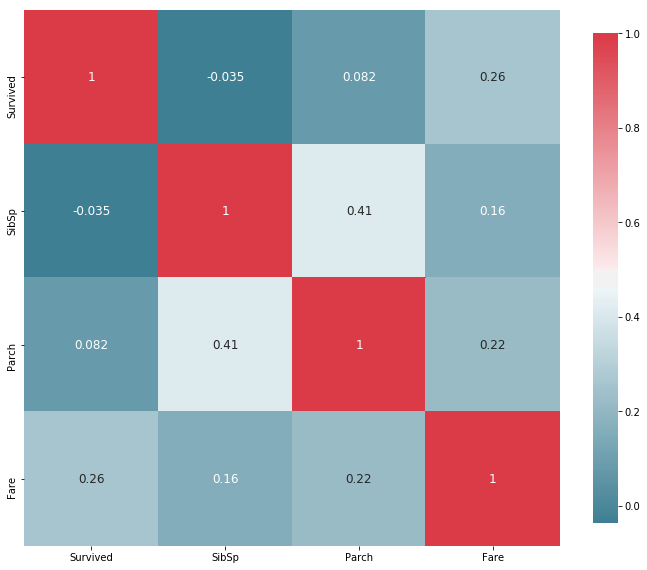

In [8]:
plot_correlation_map (data)

It can be shown that **Patch** and **SibSp** moderately depend on each other ( | r |  = 0.41). This makes sense since Parch and SipSp both regard family relationships. 

Choosing the attributes/features like this is called _pruning_ the features.

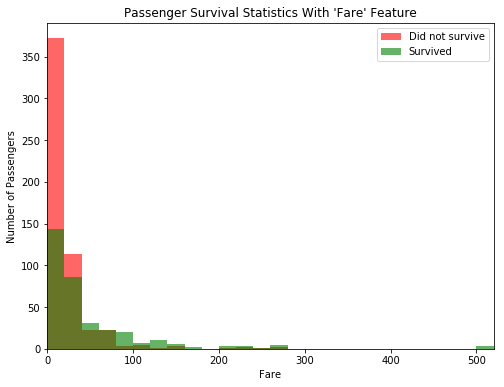

In [9]:
# Plot distributions of Fare of passangers who survived or did not survive
survival_stats(data_without_label, outcomes, 'Fare')

Consider the graph above. Differences between survival for different values is what will be used to separate the target variable - _label (survival in this case)_ in the model. If the pattern has been about the same, then it would not have been a good variable/feature for our predictive model.

It is depicted in the graph that **Fare** of **0 to 40** has a higher probability of **Dead**.

However, this feature seems not provide strong enough information to separate the label.

#### Exploring Categorical Variables


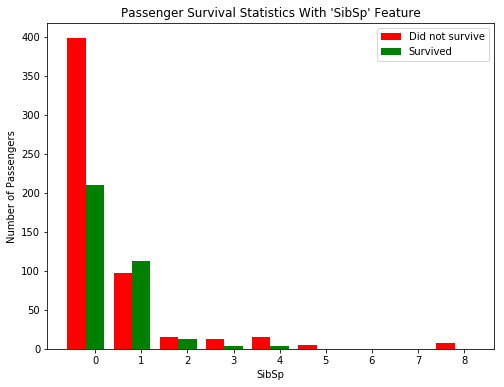

In [10]:
survival_stats(data_without_label, outcomes, 'SibSp')

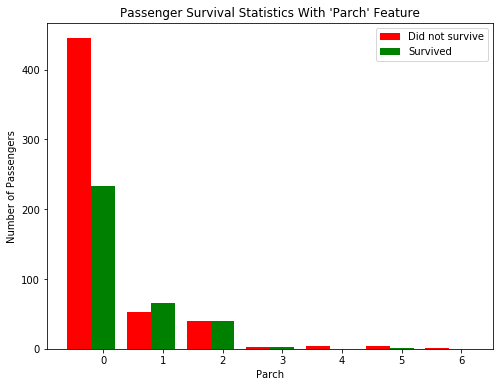

In [11]:
survival_stats(data_without_label, outcomes, 'Parch')

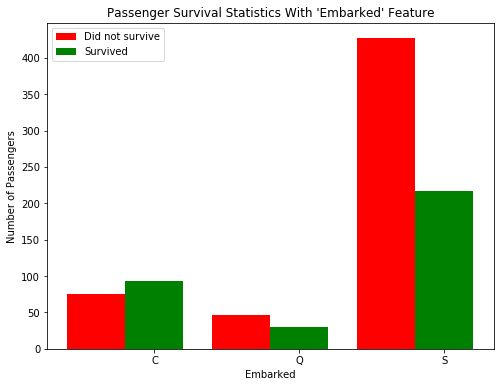

Passengers with missing 'Embarked' values: 2 (2 survived, 0 did not survive)


In [292]:
survival_stats(data_without_label, outcomes, 'Embarked')

It can be shown in the graphs for Categorical features that:
- **SibSp**: Passengers having none sibbling or spouse have higher probability of **Dead**
- **Parch**: Passengers having none parent or children have higher probability of **Dead**
- **Embarked**: Passengers embarked at Southamptom have higher probability of **Dead**

However, it is noticable these features do not provide enough useful to distinguish class label.

So i pick **Fare** as the decisive attribute and explore further SibSp, Parch and Embarked following Fare condition.

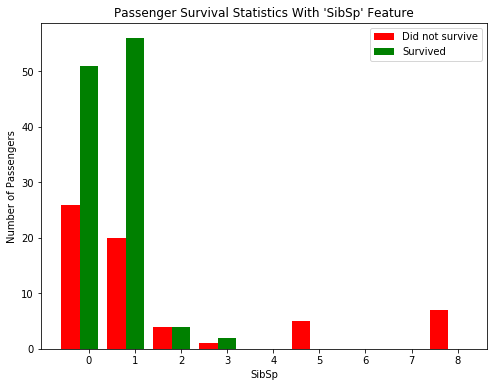

In [12]:
survival_stats(data_without_label, outcomes, 'SibSp', ["Fare > 40"])

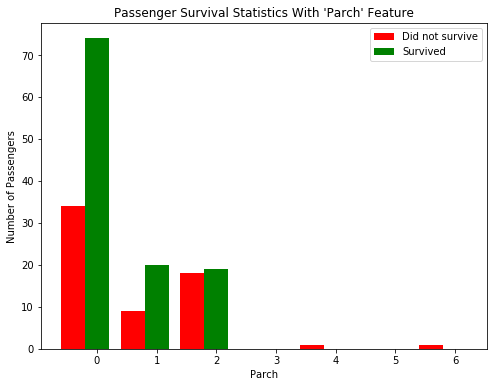

In [13]:
survival_stats(data_without_label, outcomes, 'Parch', ["Fare > 40"])

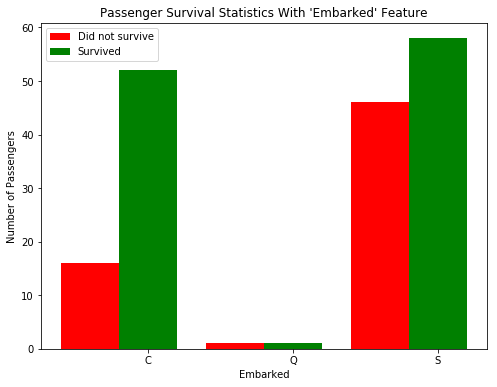

Passengers with missing 'Embarked' values: 2 (2 survived, 0 did not survive)


In [15]:
survival_stats(data_without_label, outcomes, 'Embarked', ["Fare > 40"])

It can be seen that with **Fare > 40** condition, people having SibSp > 4 will have higher probability to Die.

### Self-implemented Decision Tree

In [16]:
def decisionTreeClassifierCS(dataset):
    predictions = []
    for index, record in dataset.iterrows():
        # Survived (1) or died (0)
        if (record.Fare < 40):
            predictions.append(0)
        elif (record.SibSp > 4):
            predictions.append(0)
        else:
            predictions.append(1)
    return predictions


predictions = decisionTreeClassifierCS(data)

metrics.accuracy_score(predictions, outcomes)

#It can be shown that the accuracy is not significantly high

0.6857463524130191

### Preparing Data for Predictions

#### Transforming categorical variables to numeric variables
The variables Embarked, Pclass and Sex are treated as categorical variables. Some of our model algorithms can only handle numeric values and so we need to create a new variable (dummy variable) for every unique value of the categorical variables.

In [18]:
# Create a new variable for every unique value of Embarked
embarked = pd.get_dummies( data.Embarked , prefix='Embarked' )
# print (list(embarked.columns.values))

data_with_embarked = pd.concat ([data,embarked], axis = 1) # axis 1 - column
data_with_embarked.head()

,Survived,Name,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_C,Embarked_Q,Embarked_S
0,0,"Braund, Mr. Owen Harris",1,0,A/5 21171,7.2500,NaN,S,0,0,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,71.2833,C85,C,1,0,0
2,1,"Heikkinen, Miss. Laina",0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,113803,53.1000,C123,S,0,0,1
4,0,"Allen, Mr. William Henry",0,0,373450,8.0500,NaN,S,0,0,1


In [15]:
# Now split our data into train and test
train, test = train_test_split(data_with_embarked, test_size = 0.3)# in this our main data is splitted into train and test
# We can check their dimension
print(train.shape)
print(test.shape)
train.head(5)

(623, 11)
(268, 11)


,Survived,Name,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_C,Embarked_Q,Embarked_S
242,0,"Coleridge, Mr. Reginald Charles",0,0,W./C. 14263,10.5000,NaN,S,0,0,1
257,1,"Cherry, Miss. Gladys",0,0,110152,86.5000,B77,S,0,0,1
335,0,"Denkoff, Mr. Mitto",0,0,349225,7.8958,NaN,S,0,0,1
712,1,"Taylor, Mr. Elmer Zebley",1,0,19996,52.0000,C126,S,0,0,1
313,0,"Hendekovic, Mr. Ignjac",0,0,349243,7.8958,NaN,S,0,0,1


In [16]:
prediction_var = ['Fare','SibSp'] # features
prediction_var.extend(list(embarked.columns.values)) # Add Embarked variables
print (prediction_var)

# Below variables are used for fitting the model implemented by Sklearn
train_X = train[prediction_var] # taking the training data input 
train_y = train.Survived # This is output of our training data

# same we have to do for test
test_X = test[prediction_var] # taking test data inputs
test_y = test.Survived #output value of test data

['Fare', 'SibSp', 'Embarked_C', 'Embarked_Q', 'Embarked_S']


### Decision Tree from Sklearn

In [24]:
# Using model from sklearn library 

model = DecisionTreeClassifier()
# Fit the model:
model.fit(train_X, train_y) #Here we fit the model using training set

# Test
predictions = model.predict(test_X)
metrics.accuracy_score(predictions, test_y)

0.6604477611940298

### Exploring other features/variables

Here i consider the remaining features and explore them based on the suggestion from _interactive-data-science-tutorial_
- Name
- Cabin
- Ticket

It can be seen that we cannot explore these variables directly as same as above (too many distinct categories) but need to construct/extract new variables from these variables.

#### 1. Extract title from passenger name
Titles from the name information reflect the social level/status and may predict survival probability

  Title  Survived
0    Mr         0
1   Mrs         1
2  Miss         1
3   Mrs         1
4    Mr         0


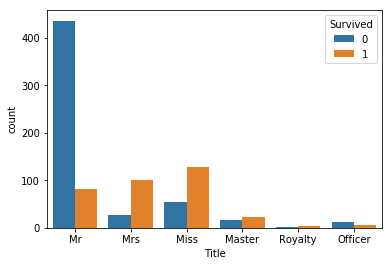

In [25]:
# Create Title variable
title = pd.DataFrame()

# Extract title from each name
# Series.map: Map values of Series using input correspondence (a dict, Series, or function).
# Lambda is one-line function. 
    # Ex: add = lambda a,b: a+b = function add (a,b): a+b
title[ 'Title' ] = data[ 'Name' ].map( lambda name: 
                                          name.split( ',' )[1].split( '.' )[0].strip() )

# A map of more aggregated titles suggested by "interactive-data-science-tutorial"
title_dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty",
                    }
# We map/convert each title to the corresponding social level based on above dictionary
title[ 'Title' ] = title.Title.map( title_dictionary )
survived = data ['Survived']
title_with_label = pd.concat( [ title, survived ] , axis=1 ) # axis 0: index, axis 1: column

print (title_with_label.head())

sns.countplot(x="Title", hue="Survived", data=title_with_label)

# Create a new variable for every unique value of Title--> Feature vectors for model implemented by sklearn
title = pd.get_dummies( title.Title ) 
# title.head(10)

#### 2. Extract Cabin category from Cabin number
Information from Cabin consists of a Cabin category (letter) and the number.

  Cabin  Survived
0     U         0
1     C         1
2     U         1
3     C         1
4     U         0


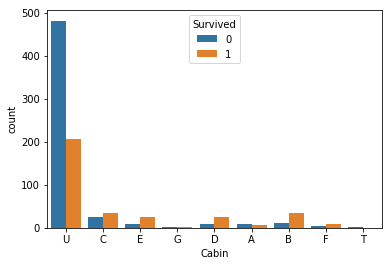

In [26]:
cabin = pd.DataFrame()

# Recall that Cabin has only 204 values, therefore, we need to fill the missing values
cabin[ 'Cabin' ] = data.Cabin.fillna( 'U' )

# mapping each Cabin value with the cabin letter
cabin[ 'Cabin' ] = cabin[ 'Cabin' ].map( lambda c : c[0] )
survived = data ['Survived']
cabin_with_label = pd.concat( [ cabin, survived ] , axis=1 ) # axis 0: index, axis 1: column

print (cabin_with_label.head())

sns.countplot(x="Cabin", hue="Survived", data=cabin_with_label)

# Create a new variable for every unique value of Cabin --> Feature vectors for model implemented by sklearn
cabin = pd.get_dummies( cabin.Cabin, prefix = 'Cabin' ) 
# cabin.head(10)

#### 3. Extract ticket class from ticket number
Information from Ticket consists of a prefix and the number, so we extract the prefixes to consider them as categorical values

   Ticket  Survived
0      A5         0
1      PC         1
2  STONO2         1
3     XXX         1
4     XXX         0


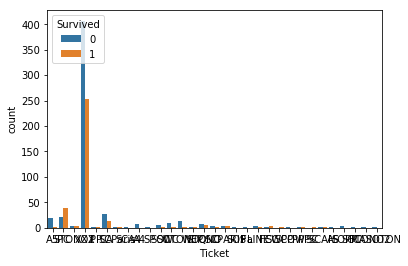

In [27]:
# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket( ticket ):
    ticket = ticket.replace( '.' , '' ) # remove dots
    ticket = ticket.replace( '/' , '' ) # remove slashes
    ticket = ticket.split() 
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()

ticket[ 'Ticket' ] = data[ 'Ticket' ].map( cleanTicket )
survived = data ['Survived']
ticket_with_label = pd.concat( [ ticket, survived ] , axis=1 ) # axis 0: index, axis 1: column

print (ticket_with_label.head())

sns.countplot(x="Ticket", hue="Survived", data=ticket_with_label)

# Create a new variable for every unique value of Ticket --> Feature vectors for model implemented by sklearn
ticket = pd.get_dummies( ticket.Ticket, prefix = 'Ticket' ) 
# ticket.head(10)

### Add Title variables to our data

In [28]:
# Add Title variable to existing data
data_new = pd.concat ([data_with_embarked,title], axis = 1)
data_new.head()

# Now split our data into train and test
train_new, test_new = train_test_split(data_new, test_size = 0.3)# in this our main data is splitted into train and test
# We can check their dimension
print(train_new.shape)
print(test_new.shape)
train_new.head(5)



(623, 17)
(268, 17)


,Survived,Name,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_C,Embarked_Q,Embarked_S,Master,Miss,Mr,Mrs,Officer,Royalty
25,1,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",1,5,347077,31.3875,NaN,S,0,0,1,0,0,0,1,0,0
471,0,"Cacic, Mr. Luka",0,0,315089,8.6625,NaN,S,0,0,1,0,0,1,0,0,0
16,0,"Rice, Master. Eugene",4,1,382652,29.1250,NaN,Q,0,1,0,1,0,0,0,0,0
639,0,"Thorneycroft, Mr. Percival",1,0,376564,16.1000,NaN,S,0,0,1,0,0,1,0,0,0
792,0,"Sage, Miss. Stella Anna",8,2,CA. 2343,69.5500,NaN,S,0,0,1,0,1,0,0,0,0


In [29]:
prediction_var.extend(list(title.columns.values))# features

print ('Features:',prediction_var)

Features: ['Fare', 'SibSp', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Master', 'Miss', 'Mr', 'Mrs', 'Officer', 'Royalty']


In [30]:
# Below variables are used for fitting the model implemented by Sklearn
train_X_new = train_new[prediction_var] # taking the training data input 
train_y_new = train_new.Survived # This is output of our training data

# same we have to do for test
test_X_new = test_new[prediction_var] # taking test data inputs
test_y_new = test_new.Survived #output value of test data


# Using model from sklearn library 
model = DecisionTreeClassifier()
# Fit the model:
model.fit(train_X_new, train_y_new) #Here we fit the model using training set

# Test
predictions = model.predict(test_X_new)
metrics.accuracy_score(predictions, test_y_new)

0.8059701492537313